# LGBM

In [27]:
%reload_ext nb_black
%reload_ext lab_black

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

import os
import random
import eli5
import warnings
import time
import math

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, accuracy_score
from eli5.sklearn import PermutationImportance
from xgboost import XGBClassifier, plot_importance

warnings.filterwarnings(action="ignore")  # 경고 출력 무시

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 1. 데이터 로딩

In [28]:
data_dir = "/opt/ml/input/data/"
csv_file_path = os.path.join(data_dir, "elo.csv")
df = pd.read_csv(csv_file_path, parse_dates=["Timestamp"])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# train, test concat

In [32]:
# df = pd.concat([train, test])
def feature_engineering_(df):

    # 유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=["userID", "Timestamp"], inplace=True)

    # 카테고리형 feature
    categories = ["assessmentItemID", "testId"]

    for category in categories:
        df[category] = df[category].astype("category")

    return df


df = feature_engineering_(df)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 2. Feature Engineering

In [33]:
def feature_engineering(df):
    print("-" * 20, "Feature Engineering Start", "-" * 20)
    start_time = time.time()

    df["hour"] = df["Timestamp"].dt.hour
    df["dow"] = df["Timestamp"].dt.dayofweek

    # 푸는 시간
    diff = (
        df.loc[:, ["userID", "Timestamp"]]
        .groupby("userID")
        .diff()
        .fillna(pd.Timedelta(seconds=0))
    )
    diff = diff.fillna(pd.Timedelta(seconds=0))
    diff = diff["Timestamp"].apply(lambda x: x.total_seconds())
    df["elapsed"] = diff
    df["elapsed"] = df["elapsed"].apply(lambda x: x if x < 650 and x >= 0 else 0)

    df["grade"] = df["testId"].apply(lambda x: int(x[1:4]) // 10)
    df["mid"] = df["testId"].apply(lambda x: int(x[-3:]))
    df["problem_number"] = df["assessmentItemID"].apply(lambda x: int(x[-3:]))

    correct_h = df.groupby(["hour"])["answerCode"].agg(["mean", "sum"])
    correct_h.columns = ["hour_mean", "hour_sum"]
    correct_d = df.groupby(["dow"])["answerCode"].agg(["mean", "sum"])
    correct_d.columns = ["dow_mean", "dow_sum"]
    correct_t = df.groupby(["testId"])["answerCode"].agg(["mean", "sum"])
    correct_t.columns = ["test_mean", "test_sum"]
    correct_k = df.groupby(["KnowledgeTag"])["answerCode"].agg(["mean", "sum"])
    correct_k.columns = ["KnowledgeTag_mean", "KnowledgeTag_sum"]
    correct_a = df.groupby(["assessmentItemID"])["answerCode"].agg(["mean", "sum"])
    correct_a.columns = ["assessmentItemID_mean", "assessmentItemID_sum"]
    correct_p = df.groupby(["problem_number"])["answerCode"].agg(["mean", "sum"])
    correct_p.columns = ["problem_number_mean", "problem_number_sum"]

    df = pd.merge(df, correct_t, on=["testId"], how="left")
    df = pd.merge(df, correct_k, on=["KnowledgeTag"], how="left")
    df = pd.merge(df, correct_a, on=["assessmentItemID"], how="left")
    df = pd.merge(df, correct_p, on=["problem_number"], how="left")
    df = pd.merge(df, correct_h, on=["hour"], how="left")
    df = pd.merge(df, correct_d, on=["dow"], how="left")

    o_df = df[df["answerCode"] == 1]
    x_df = df[df["answerCode"] == 0]

    elp_k = df.groupby(["KnowledgeTag"])["elapsed"].agg("mean").reset_index()
    elp_k.columns = ["KnowledgeTag", "tag_elp"]
    elp_k_o = o_df.groupby(["KnowledgeTag"])["elapsed"].agg("mean").reset_index()
    elp_k_o.columns = ["KnowledgeTag", "tag_elp_o"]
    elp_k_x = x_df.groupby(["KnowledgeTag"])["elapsed"].agg("mean").reset_index()
    elp_k_x.columns = ["KnowledgeTag", "tag_elp_x"]

    df = pd.merge(df, elp_k, on=["KnowledgeTag"], how="left")
    df = pd.merge(df, elp_k_o, on=["KnowledgeTag"], how="left")
    df = pd.merge(df, elp_k_x, on=["KnowledgeTag"], how="left")

    ass_k = df.groupby(["assessmentItemID"])["elapsed"].agg("mean").reset_index()
    ass_k.columns = ["assessmentItemID", "ass_elp"]
    ass_k_o = o_df.groupby(["assessmentItemID"])["elapsed"].agg("mean").reset_index()
    ass_k_o.columns = ["assessmentItemID", "ass_elp_o"]
    ass_k_x = x_df.groupby(["assessmentItemID"])["elapsed"].agg("mean").reset_index()
    ass_k_x.columns = ["assessmentItemID", "ass_elp_x"]

    df = pd.merge(df, ass_k, on=["assessmentItemID"], how="left")
    df = pd.merge(df, ass_k_o, on=["assessmentItemID"], how="left")
    df = pd.merge(df, ass_k_x, on=["assessmentItemID"], how="left")

    prb_k = df.groupby(["problem_number"])["elapsed"].agg("mean").reset_index()
    prb_k.columns = ["problem_number", "prb_elp"]
    prb_k_o = o_df.groupby(["problem_number"])["elapsed"].agg("mean").reset_index()
    prb_k_o.columns = ["problem_number", "prb_elp_o"]
    prb_k_x = x_df.groupby(["problem_number"])["elapsed"].agg("mean").reset_index()
    prb_k_x.columns = ["problem_number", "prb_elp_x"]

    df = pd.merge(df, prb_k, on=["problem_number"], how="left")
    df = pd.merge(df, prb_k_o, on=["problem_number"], how="left")
    df = pd.merge(df, prb_k_x, on=["problem_number"], how="left")

    df["user_correct_answer"] = (
        df.groupby("userID")["answerCode"]
        .transform(lambda x: x.cumsum().shift(1))
        .fillna(0)
    )
    df["user_total_answer"] = df.groupby("userID")["answerCode"].cumcount()
    df["user_acc"] = (df["user_correct_answer"] / df["user_total_answer"]).fillna(0)
    df["Grade_o"] = (
        df.groupby(["userID", "grade"])["answerCode"]
        .transform(lambda x: x.cumsum().shift(1))
        .fillna(0)
    )
    df["GradeCount"] = df.groupby(["userID", "grade"]).cumcount()
    df["GradeAcc"] = (df["Grade_o"] / df["GradeCount"]).fillna(0)
    df["GradeElp"] = (
        df.groupby(["userID", "grade"])["elapsed"]
        .transform(lambda x: x.cumsum())
        .fillna(0)
    )
    df["GradeMElp"] = df["GradeElp"] / [
        v if v != 0 else 1 for v in df["GradeCount"].values
    ]

    f = lambda x: len(set(x))
    test = df.groupby(["testId"]).agg({"problem_number": "max", "KnowledgeTag": f})
    test.reset_index(inplace=True)

    test.columns = ["testId", "problem_count", "tag_count"]

    df = pd.merge(df, test, on="testId", how="left")

    gdf = df[["userID", "testId", "problem_number", "grade", "Timestamp"]].sort_values(
        by=["userID", "grade", "Timestamp"]
    )
    gdf["buserID"] = gdf["userID"] != gdf["userID"].shift(1)
    gdf["bgrade"] = gdf["grade"] != gdf["grade"].shift(1)
    gdf["first"] = gdf[["buserID", "bgrade"]].any(axis=1).apply(lambda x: 1 - int(x))
    gdf["RepeatedTime"] = gdf["Timestamp"].diff().fillna(pd.Timedelta(seconds=0))
    gdf["RepeatedTime"] = (
        gdf["RepeatedTime"].apply(lambda x: x.total_seconds()) * gdf["first"]
    )
    df["RepeatedTime"] = gdf["RepeatedTime"].apply(lambda x: math.log(x + 1))

    df["prior_KnowledgeTag_frequency"] = df.groupby(
        ["userID", "KnowledgeTag"]
    ).cumcount()

    df["problem_position"] = df["problem_number"] / df["problem_count"]
    df["solve_order"] = df.groupby(["userID", "testId"]).cumcount()
    df["solve_order"] = (
        df["solve_order"]
        - df["problem_count"] * (df["solve_order"] > df["problem_count"]).apply(int)
        + 1
    )

    df["retest"] = (df["solve_order"] > df["problem_count"]).apply(int)
    T = df["solve_order"] != df["problem_number"]
    TT = T.shift(1)
    TT[0] = False
    df["solved_disorder"] = (TT.apply(lambda x: not x) & T).apply(int)

    df["testId"] = df["testId"].apply(lambda x: int(x[1:4] + x[-3]))

    print("-" * 20, "Feature Engineering End", "-" * 20)
    print(f"Feature Engineering에 걸린 시간 : {time.time() - start_time}s")

    return df

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
df = feature_engineering(df)

-------------------- Feature Engineering Start --------------------
-------------------- Feature Engineering End --------------------
Feature Engineering에 걸린 시간 : 59.13851594924927s


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
import gc

gc.get_count()
gc.collect()
gc.get_count()

(37, 0, 0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 3. Train/Test 데이터 셋 분리

- 아래와 같이 split을 진행함
- custom split은 필수적임, 맨마지막 interaction을 가져와야 되니까
- 반복문을 이용해서 train 시키고, 나눠주면 될 듯

In [36]:
# Inference 위해 미리 나누어 놓음
# train = df[df.dataset == 1]
# test = test = df[df.dataset == 2]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
def all_train_valid_split(df):
    train = df[df.dataset == 1]

    test = df[(df.dataset == 2) & (df.answerCode != -1)]  # -1 인 answerCode 제외

    test = test[test["userID"] != test["userID"].shift(-1)]

    return train, test

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
# train과 valid 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)


def custom_train_valid_split(df, ratio=0.9, split=True):

    users = list(zip(df["userID"].value_counts().index, df["userID"].value_counts()))
    random.shuffle(users)

    max_train_data_len = ratio * len(df)
    sum_of_train_data = 0
    user_ids = []

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)

    train = df[df["userID"].isin(user_ids)]
    valid = df[df["userID"].isin(user_ids) == False]

    # valid데이터셋은 각 유저의 마지막 interaction만 추출
    valid = valid[valid["userID"] != valid["userID"].shift(-1)]

    return train, valid

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
# 유저별 분리
train, valid = custom_train_valid_split(df[df.dataset == 1])

# 사용할 Feature 설정
FEATS = [
    "GradeAcc",
    "GradeCount",
    "GradeElp",
    "GradeMElp",
    "Grade_o",
    "KnowledgeTag",
    "KnowledgeTag_mean",
    "KnowledgeTag_sum",
    "RepeatedTime",
    # "Timestamp",
    #  'answerCode',
    "ass_elp",
    "ass_elp_o",
    "ass_elp_x",
    # "assessmentItemID",
    "assessmentItemID_mean",
    "assessmentItemID_sum",
    "dataset",
    "dow",
    "dow_mean",
    "dow_sum",
    "elapsed",
    "elo",
    "grade",
    "hour",
    "hour_mean",
    "hour_sum",
    "mid",
    "prb_elp",
    "prb_elp_o",
    "prb_elp_x",
    "prior_KnowledgeTag_frequency",
    "problem_count",
    "problem_number",
    "problem_number_mean",
    "problem_number_sum",
    "problem_position",
    "retest",
    "solve_order",
    "solved_disorder",
    "tag_count",
    "tag_elp",
    "tag_elp_o",
    "tag_elp_x",
    "testId",
    "test_mean",
    "test_sum",
    #  'userID',
    "user_acc",
    "user_correct_answer",
    "user_total_answer",
]


y_train = train["answerCode"]
train = train.drop(["answerCode"], axis=1)

y_valid = valid["answerCode"]
valid = valid.drop(["answerCode"], axis=1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
# dataset에 포함된 feature 목록
sorted(list(df.columns))

['GradeAcc',
 'GradeCount',
 'GradeElp',
 'GradeMElp',
 'Grade_o',
 'KnowledgeTag',
 'KnowledgeTag_mean',
 'KnowledgeTag_sum',
 'RepeatedTime',
 'Timestamp',
 'answerCode',
 'ass_elp',
 'ass_elp_o',
 'ass_elp_x',
 'assessmentItemID',
 'assessmentItemID_mean',
 'assessmentItemID_sum',
 'dataset',
 'dow',
 'dow_mean',
 'dow_sum',
 'elapsed',
 'elo',
 'grade',
 'hour',
 'hour_mean',
 'hour_sum',
 'mid',
 'prb_elp',
 'prb_elp_o',
 'prb_elp_x',
 'prior_KnowledgeTag_frequency',
 'problem_count',
 'problem_number',
 'problem_number_mean',
 'problem_number_sum',
 'problem_position',
 'retest',
 'solve_order',
 'solved_disorder',
 'tag_count',
 'tag_elp',
 'tag_elp_o',
 'tag_elp_x',
 'testId',
 'test_mean',
 'test_sum',
 'userID',
 'user_acc',
 'user_correct_answer',
 'user_total_answer']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 4. 훈련 및 검증

In [59]:
model = XGBClassifier(
    booster="gbtree",
    colsample_bylevel=0.8,
    colsample_bytree=0.8,
    gamma=0,
    max_depth=8,
    min_child_weight=4,
    n_estimators=70,
    nthread=4,
    objective="binary:logistic",
    # metrics="auc",
    random_state=42,
    # silent=True,
    # enable_categorical=True,
)

# 🌟 XGBoost 모델 학습
model.fit(
    X=train[FEATS],
    y=y_train,
    eval_set=[(valid[FEATS], y_valid)],
    eval_metric="auc",
    early_stopping_rounds=100,
    verbose=5,
)

[0]	validation_0-auc:0.81578
[5]	validation_0-auc:0.82255
[10]	validation_0-auc:0.82690
[15]	validation_0-auc:0.82920
[20]	validation_0-auc:0.82935
[25]	validation_0-auc:0.83096
[30]	validation_0-auc:0.83260
[35]	validation_0-auc:0.83248
[40]	validation_0-auc:0.83374
[45]	validation_0-auc:0.83367
[50]	validation_0-auc:0.83449
[55]	validation_0-auc:0.83425
[60]	validation_0-auc:0.83430
[65]	validation_0-auc:0.83455
[69]	validation_0-auc:0.83486


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.8, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=4,
              missing=nan, monotone_constraints='()', n_estimators=70, n_jobs=4,
              nthread=4, num_parallel_tree=1, predictor='auto', ...)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

VALID AUC : 0.8349027052681537 ACC : 0.7572964669738863

['tag_count', 'tag_elp', 'tag_elp_o', 'tag_elp_x', 'RepeatedTime', 'retest', 'testId', 'test_mean', 'test_sum', 'mid', 'elapsed', 'elo', 'KnowledgeTag', 'KnowledgeTag_mean', 'KnowledgeTag_sum', 'dow', 'dow_mean', 'dow_sum', 'hour', 'hour_mean', 'hour_sum', 'solve_order', 'solved_disorder', 'GradeAcc', 'GradeCount', 'GradeElp', 'GradeMElp', 'Grade_o', 'grade', 'prb_elp', 'prb_elp_o', 'prb_elp_x', 'prior_KnowledgeTag_frequency', 'problem_count', 'problem_number', 'problem_number_mean', 'problem_number_sum', 'problem_position', 'ass_elp', 'ass_elp_o', 'ass_elp_x', 'assessmentItemID_mean', 'assessmentItemID_sum', 'user_acc', 'user_correct_answer', 'user_total_answer']


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

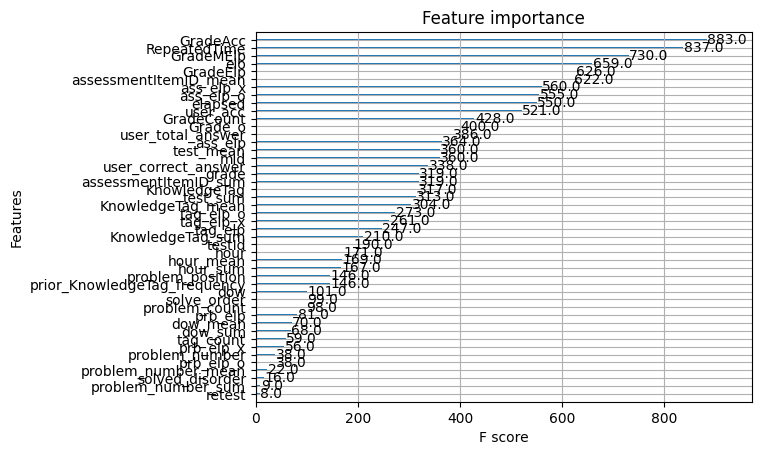

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [60]:
#  XGBoost 모델 추론
preds = model.predict_proba(valid[FEATS])[:, 1]
acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_valid, preds)

print(f"VALID AUC : {auc} ACC : {acc}\n")

# feature 중요도 출력
fscore = model.get_booster().get_fscore()
print(sorted(fscore, key=lambda x: x[1]))

plot_importance(model)

# CV - Optuna

## seed 고정 필요

In [93]:
np.random.seed(42)
user_idx = df[df.dataset == 1]["userID"].unique()
np.random.shuffle(user_idx)
user_idx

array([2104, 2930,  550, ..., 5808, 5992,  967])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [97]:
df[df.dataset == 1]["userID"].nunique()

6698

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [98]:
folds = []
for i in range(1, 6):
    start = (6698 // 5) * (i - 1)
    end = (6698 // 5) * i

    valid_idx = user_idx[start:end]
    train_idx = list(user_idx[:start]) + list(user_idx[end:])

    folds.append((valid_idx, train_idx))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [99]:
# folds[0] = list(folds[0])
# folds[1] = list(folds[1])
# folds[0][0] = list(folds[0][0]) + list(folds[1][0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [100]:
for i in range(5):
    print(len(folds[i][0]))

1339
1339
1339
1339
1339


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [101]:
df.loc[df["userID"].isin(folds[0][1]), :]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,dataset,elo,hour,dow,...,GradeElp,GradeMElp,problem_count,tag_count,RepeatedTime,prior_KnowledgeTag_frequency,problem_position,solve_order,retest,solved_disorder
0,0,A060001001,600,1,2020-03-24 00:17:11,7224,1,0.980768,0,1,...,0.0,0.000000,7,2,0.000000,0,0.142857,1,0,0
1,0,A060001002,600,1,2020-03-24 00:17:14,7225,1,0.973315,0,1,...,3.0,3.000000,7,2,1.386294,0,0.285714,2,0,0
2,0,A060001003,600,1,2020-03-24 00:17:22,7225,1,0.947292,0,1,...,11.0,5.500000,7,2,2.197225,1,0.428571,3,0,0
3,0,A060001004,600,1,2020-03-24 00:17:29,7225,1,0.974914,0,1,...,18.0,6.000000,7,2,2.079442,2,0.571429,4,0,0
4,0,A060001005,600,1,2020-03-24 00:17:36,7225,1,0.961391,0,1,...,25.0,6.250000,7,2,2.079442,3,0.714286,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,7441,A030071005,300,0,2020-06-05 06:50:21,438,1,0.296188,6,4,...,220.0,55.000000,5,1,3.218876,4,1.000000,5,0,0
2526696,7441,A040165001,401,1,2020-08-21 01:06:39,8836,1,0.616957,1,4,...,0.0,0.000000,4,1,0.000000,0,0.250000,1,0,0
2526697,7441,A040165002,401,1,2020-08-21 01:06:50,8836,1,0.601200,1,4,...,11.0,11.000000,4,1,2.484907,1,0.500000,2,0,0
2526698,7441,A040165003,401,1,2020-08-21 01:07:36,8836,1,0.726027,1,4,...,57.0,28.500000,4,1,3.850148,2,0.750000,3,0,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [102]:
test_df = df[df.dataset == 2]
# test_df = test
# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df["userID"] != test_df["userID"].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(["answerCode"], axis=1)

# MAKE PREDICTION
# total_preds = model.predict(test_df[FEATS])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [110]:
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner


def objective(trial):

    param = {
        "max_depth": trial.suggest_int("max_depth", 2, 15),
        "subsample": trial.suggest_discrete_uniform("subsample", 0.6, 1.0, 0.05),
        "n_estimators": trial.suggest_int("n_estimators", 1000, 10000, 100),
        "eta": trial.suggest_discrete_uniform("eta", 0.01, 0.1, 0.01),
        "reg_alpha": trial.suggest_int("reg_alpha", 1, 50),
        "reg_lambda": trial.suggest_int("reg_lambda", 5, 100),
        "min_child_weight": trial.suggest_int("min_child_weight", 2, 20),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
    }

    model = XGBClassifier(**param, objective="binary:logistic")
    model.fit(
        train,
        y_train,
        eval_set=[(valid, y_valid)],
        eval_metric="auc",
        verbose=False,
        early_stopping_rounds=150,
    )
    preds = model.predict_proba(valid)[:, 1]

    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)

    return auc


for fold in range(0, 5):
    print(
        f"===================================={fold+1}============================================"
    )

    valid_idx, train_idx = folds[fold]

    train = df.loc[df["userID"].isin(train_idx), :]
    y_train = train["answerCode"]
    train = train[FEATS]

    valid = df.loc[df["userID"].isin(valid_idx), :]
    valid = valid[valid["userID"] != valid["userID"].shift(-1)]
    
    y_valid = valid["answerCode"]
    valid = valid[FEATS]

    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(
        study_name="XGB_parameter_opt",
        direction="maximize",
        sampler=sampler,
    )

    study.optimize(objective, n_trials=10)

    # Inference
    model = XGBClassifier(**study.best_params, objective="binary:logistic")
    model.fit(
        train,
        y_train,
        eval_set=[(valid, y_valid)],
        eval_metric="auc",
        verbose=False,
        early_stopping_rounds=100,
    )

    pred = model.predict_proba(test_df[FEATS])[:, 1]
    test_df[f"pred_{fold}"] = pred
    print(
        f"================================================================================\n\n"
    )

====================================1============================================


[I 2022-12-08 05:03:51,978] A new study created in memory with name: XGB_parameter_opt
[W 2022-12-08 05:03:53,626] Trial 0 failed because of the following error: ValueError('too many values to unpack (expected 2)')
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_117377/2582206855.py", line 20, in objective
    model.fit(
  File "/opt/conda/lib/python3.8/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py", line 1497, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py", line 485, in _wrap_evaluation_matrices
    for i, (valid_X, valid_y) in enumerate(eval_set):
ValueError: too many values to unpack (expected 2)


ValueError: too many values to unpack (expected 2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 5. Inference

In [104]:
total_preds = (
    test_df["pred_0"]
    + test_df["pred_1"]
    + test_df["pred_2"]
    + test_df["pred_3"]
    + test_df["pred_4"]
) / 5  # //+test_df['pred_5'] +
# test_df['pred_6'] + test_df['pred_7'] + test_df['pred_8'] + test_df['pred_9']) / 10
# total_preds = (test_df['pred_0'] + test_df['pred_1'] + test_df['pred_2'] + test_df['pred_3'] + test_df['pred_4'] +test_df['pred_5'] +
# test_df['pred_6'] + test_df['pred_7'] + test_df['pred_8'] + test_df['pred_9'] ) / 10
# test = test_df[['userID', 'rating']]
# test.to_csv('../submit/CAT_10Fold.csv', index = False)
# test.to_csv('submit/LGBM.csv', index = False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [61]:
test_df = df[df.dataset == 2]
# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df["userID"] != test_df["userID"].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(["answerCode"], axis=1)

# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [62]:
# test_df[FEATS]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [105]:
# SAVE OUTPUT
output_dir = "output/"
write_path = os.path.join(output_dir, "LJH_Last_LGBM.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, "w", encoding="utf8") as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write("{},{}\n".format(id, p))

writing prediction : output/LJH_Last_LGBM.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.

